In [1]:
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os

# ERA5

In [9]:
os.path.getsize(path)/1024**3,'GB'

(6.131851673126221, 'GB')

In [4]:
path='/work/bk1099/data/sf00_MM/2000-2009/E5sf00_MM_2000-2009.grb'
v='T2M'

### cdo

In [3]:
import cdo
cdo = cdo.Cdo()

In [39]:
# https://code.mpimet.mpg.de/boards/2/topics/2343
%time ds_cdo = cdo.setgridtype('regular',input=f'{path}', returnXArray=v, options='-f nc4 -t ecmwf').squeeze()

CPU times: user 224 ms, sys: 102 ms, total: 326 ms
Wall time: 1min 34s


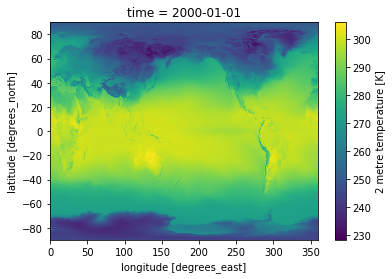

In [45]:
ds_cdo.isel(time=0).plot()

# xarray
### cfgrib

In [4]:
import cfgrib

def pre(ds,v=v):
    return ds.isel(time=0).squeeze()[v].to_dataset(name=v)

NameError: name 'v' is not defined

In [48]:
%time ds = xr.open_dataset(path, engine='cfgrib', chunks={'time':'auto'}, backend_kwargs={"indexpath": "", 'filter_by_keys': {'typeOfLevel': 'surface'}})

CPU times: user 1min 2s, sys: 1.73 s, total: 1min 4s
Wall time: 1min 4s


In [42]:
%%time
ds = xr.open_mfdataset(path, engine='cfgrib', chunks={'time':'auto'}, backend_kwargs={"indexpath": "", 'filter_by_keys': {'typeOfLevel': 'surface'}},
                       preprocess=pre, combine='nested', concat_dim='time')

CPU times: user 1min 1s, sys: 1.8 s, total: 1min 3s
Wall time: 1min 3s


In [41]:
ds

<xarray.Dataset>
Dimensions:     (values: 542080)
Coordinates:
    number      int64 ...
    time        datetime64[ns] 2000-01-01
    step        timedelta64[ns] ...
    surface     int64 ...
    latitude    (values) float64 dask.array<chunksize=(542080,), meta=np.ndarray>
    longitude   (values) float64 dask.array<chunksize=(542080,), meta=np.ndarray>
    valid_time  datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
Dimensions without coordinates: values
Data variables:
    cvl         (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    cvh         (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    tvl         (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    tvh         (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    siconc      (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    asn         (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    rsn         (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    sst         (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    z           (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    sp          (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    tcw         (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    tcwv        (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    sd          (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    msl         (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    sdor        (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    isor        (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    anor        (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    slor        (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    tcc         (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    u10         (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    v10         (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    t2m         (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    d2m         (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    lsm         (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    lcc         (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    mcc         (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    hcc         (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    src         (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    tco3        (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    skt         (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    tsn         (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    fal         (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    fsr         (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
    flsr        (values) float32 dask.array<chunksize=(542080,), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2020-04-01T11:53:07 GRIB to CDM+CF via cfgrib-0....

In [36]:
def convert_reduced_to_reg_grid(ds):
    #https://stackoverflow.com/questions/59845442/how-to-reshape-xarray-data-with-new-dimensions

    import pandas as pd
    index = pd.MultiIndex.from_arrays(
        [ds.longitude.values, ds.latitude.values], names=['lon', 'lat']
    )
    ds['values'] = index
    reshaped = ds.unstack('values')
    return reshaped

In [43]:
%time ds = convert_reduced_to_reg_grid(ds)
ds

CPU times: user 39.5 s, sys: 11.7 s, total: 51.2 s
Wall time: 51 s


<xarray.Dataset>
Dimensions:     (lat: 640, lon: 11942, time: 1)
Coordinates:
    step        timedelta64[ns] ...
    longitude   (lon, lat) float64 dask.array<chunksize=(11942, 640), meta=np.ndarray>
    valid_time  datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    latitude    (lon, lat) float64 dask.array<chunksize=(11942, 640), meta=np.ndarray>
    number      int64 ...
    surface     int64 ...
  * time        (time) datetime64[ns] 2000-01-01
  * lon         (lon) float64 0.0 0.2812 0.2963 0.3 ... 359.7 359.7 359.7 359.7
  * lat         (lat) float64 -89.78 -89.51 -89.23 -88.95 ... 89.23 89.51 89.78
Data variables:
    cvl         (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    cvh         (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    tvl         (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    tvh         (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    siconc      (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    asn         (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    rsn         (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    sst         (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    z           (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    sp          (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    tcw         (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    tcwv        (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    sd          (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    msl         (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    sdor        (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    isor        (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    anor        (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    slor        (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    tcc         (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    u10         (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    v10         (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    t2m         (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    d2m         (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    lsm         (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    lcc         (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    mcc         (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    hcc         (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    src         (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    tco3        (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    skt         (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    tsn         (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    fal         (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    fsr         (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
    flsr        (time, lon, lat) float32 dask.array<chunksize=(1, 11942, 640), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescri

### pynio
does not get coordinates and variables names

In [46]:
%time ds = xr.open_dataset(path, engine='pynio', chunks={})

CPU times: user 43 ms, sys: 3 ms, total: 46 ms
Wall time: 42.6 ms


In [47]:
ds

<xarray.Dataset>
Dimensions:                (g4_lat_1: 640, g4_lon_2: 1280, initial_time0_hours: 120)
Coordinates:
  * initial_time0_hours    (initial_time0_hours) datetime64[ns] 2000-01-01 ... 2009-12-01
  * g4_lat_1               (g4_lat_1) float32 89.784874 89.5062 ... -89.784874
  * g4_lon_2               (g4_lon_2) float32 0.0 0.2812494 ... 359.718
Data variables:
    CVL_GDS4_SFC_S123      (initial_time0_hours, g4_lat_1, g4_lon_2) float32 dask.array<chunksize=(120, 640, 1280), meta=np.ndarray>
    CVH_GDS4_SFC_S123      (initial_time0_hours, g4_lat_1, g4_lon_2) float32 dask.array<chunksize=(120, 640, 1280), meta=np.ndarray>
    TVL_GDS4_SFC_S123      (initial_time0_hours, g4_lat_1, g4_lon_2) float32 dask.array<chunksize=(120, 640, 1280), meta=np.ndarray>
    TVH_GDS4_SFC_S123      (initial_time0_hours, g4_lat_1, g4_lon_2) float32 dask.array<chunksize=(120, 640, 1280), meta=np.ndarray>
    CI_GDS4_SFC_S123       (initial_time0_hours, g4_lat_1, g4_lon_2) float32 dask.array<chunksize=(120, 640, 1280), meta=np.ndarray>
    ASN_GDS4_SFC_S123      (initial_time0_hours, g4_lat_1, g4_lon_2) float32 dask.array<chunksize=(120, 640, 1280), meta=np.ndarray>
    RSN_GDS4_SFC_S123      (initial_time0_hours, g4_lat_1, g4_lon_2) float32 dask.array<chunksize=(120, 640, 1280), meta=np.ndarray>
    SSTK_GDS4_SFC_S123     (initial_time0_hours, g4_lat_1, g4_lon_2) float32 dask.array<chunksize=(120, 640, 1280), meta=np.ndarray>
    ISTL1_GDS4_DBLY_S123   (initial_time0_hours, g4_lat_1, g4_lon_2) float32 dask.array<chunksize=(120, 640, 1280), meta=np.ndarray>
    ISTL2_GDS4_DBLY_S123   (initial_time0_hours, g4_lat_1, g4_lon_2) float32 dask.array<chunksize=(120, 640, 1280), meta=np.ndarray>
    ISTL3_GDS4_DBLY_S123   (initial_time0_hours, g4_lat_1, g4_lon_2) float32 dask.array<chunksize=(120, 640, 1280), meta=np.ndarray>
    ISTL4_GDS4_DBLY_S123   (initial_time0_hours, g4_lat_1, g4_lon_2) float32 dask.array<chunksize=(120, 640, 1280), meta=np.ndarray>
    SWVL1_GDS4_DBLY_S123   (initial_time0_hours, g4_lat_1, g4_lon_2) float32 dask.array<chunksize=(120, 640, 1280), meta=np.ndarray>
    SWVL2_GDS4_DBLY_S123   (initial_time0_hours, g4_lat_1, g4_lon_2) float32 dask.array<chunksize=(120, 640, 1280), meta=np.ndarray>
    SWVL3_GDS4_DBLY_S123   (initial_time0_hours, g4_lat_1, g4_lon_2) float32 dask.array<chunksize=(120, 640, 1280), meta=np.ndarray>
    SWVL4_GDS4_DBLY_S123   (initial_time0_hours, g4_lat_1, g4_lon_2) float32 dask.array<chunksize=(120, 640, 1280), meta=np.ndarray>
    Z_GDS4_SFC_S123        (initial_time0_hours, g4_lat_1, g4_lon_2) float32 dask.array<chunksize=(120, 640, 1280), meta=np.ndarray>
    SP_GDS4_SFC_S123       (initial_time0_hours, g4_lat_1, g4_lon_2) float32 dask.array<chunksize=(120, 640, 1280), meta=np.ndarray>
    TCW_GDS4_SFC_S123      (initial_time0_hours, g4_lat_1, g4_lon_2) float32 dask.array<chunksize=(120, 640, 1280), meta=np.ndarray>
    TCWV_GDS4_SFC_S123     (initial_time0_hours, g4_lat_1, g4_lon_2) float32 dask.array<chunksize=(120, 640, 1280), meta=np.ndarray>
    STL1_GDS4_DBLY_S123    (initial_time0_hours, g4_lat_1, g4_lon_2) float32 dask.array<chunksize=(120, 640, 1280), meta=np.ndarray>
    SD_GDS4_SFC_S123       (initial_time0_hours, g4_lat_1, g4_lon_2) float32 dask.array<chunksize=(120, 640, 1280), meta=np.ndarray>
    MSL_GDS4_SFC_S123      (initial_time0_hours, g4_lat_1, g4_lon_2) float32 dask.array<chunksize=(120, 640, 1280), meta=np.ndarray>
    SDOR_GDS4_SFC_S123     (initial_time0_hours, g4_lat_1, g4_lon_2) float32 dask.array<chunksize=(120, 640, 1280), meta=np.ndarray>
    ISOR_GDS4_SFC_S123     (initial_time0_hours, g4_lat_1, g4_lon_2) float32 dask.array<chunksize=(120, 640, 1280), meta=np.ndarray>
    ANOR_GDS4_SFC_S123     (initial_time0_hours, g4_lat_1, g4_lon_2) float32 dask.array<chunksize=(120, 640, 1280), meta=np.ndarray>
    SLOR_GDS4_SFC_S123     (initial_time0_hours, g4_lat_1, g4_lon_2) float32 dask.array<chunksize=(120, 640, 1280), meta=np.ndarray>
    TCC_GDS4_SFC_S123      (initial_t

# ERA-interim

In [5]:
path = '/pool/data/nudging/'

In [9]:
!ls -all /pool/data/nudging/

total 164
drwxr-x--x  8 m218036 ndg   4096 Jul  4  2018 .
drwxr-xr-x 28 root    root  4096 Mar 30 08:58 ..
dr-xrwx---  4 m218036 ndg  12288 Feb 26 09:58 ana
lrwxrwxrwx  1 m218036 ndg      3 Aug 16  2010 analysis -> ana
drwxrwx---  8 m218036 ndg  36864 Oct 29  2014 era40
drwxr-x---  4 m218036 ndg  36864 Mar  9 16:59 era5_
dr-xrwx--- 16 m218036 ndg  36864 Jun 21  2019 eraia
-rw-r-----  1 m218036 ndg  10240 Dec  9  2011 T63L31
drwxr-xr-x  2 m218036 ndg   4096 May 30  2018 templates
drwx------  7 m218036 ndg  20480 Mar  9 16:59 tmp
